# Analyses - Figure 5, S9

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import scanpy.api as sc
import matplotlib as mpl
from matplotlib import rcParams

import seaborn as sns
import scipy as sci

import gseapy as gp
from xlrd import XLRDError
import xlsxwriter

/Users/sophie/miniconda3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()

scanpy==1.0.4+92.g9a754bb.dirty anndata==0.5.10 numpy==1.14.2 scipy==1.0.1 pandas==0.22.0 scikit-learn==0.19.1 statsmodels==0.8.0 python-igraph==0.7.1 louvain==0.6.1 


In [3]:
sc.settings.writedir='./data/'
sc.settings.figdir='./figures/'

In [4]:
sc.set_figure_params(vector_friendly=True, color_map='RdBu_r', dpi_save=300)

In [5]:
adata_all = sc.read('./data/adata_processed.h5')

In [6]:
adata_all_hvg = adata_all[:, adata_all.var.highly_variable].copy()

## Wnt signaling score

In [7]:
wnt_genes= ['Lgr5', 'Ascl2', 'Ccnd1', 'Ppard', 'Cd44', 'Tcf1', 'Axin2', 'Myc', 'Mycn', 
            'Bmp4', 'Jag1','Jag2', 'Sox9', 'Ephb4', 'Mmp7', 'Fzd2', 'Fzd7']
sc.tl.score_genes(adata_all, wnt_genes, n_bins=25, score_name='Wnt signaling')

computing score 'Wnt signaling'
['Zfp174', '2210016F16Rik', 'Tnpo1', 'Bag2', 'Rtn4r', 'Gatm', 'Hnrnpul1', 'Bag6', 'Hnf4g', 'Tstd3', 'Pank3', 'Sprr2a3', 'AI467606', 'Upk1a', 'Dcaf11', 'Cyp2c40', 'Gsdmc4', 'Plxna3', 'Tbc1d2', 'Scaf8', 'Il25', 'Dbt', '3110040N11Rik', 'Mfsd6l', 'Asnsd1', 'Lims1', 'Atp13a1', 'Clint1', 'Apool', 'Dbn1', 'Rps6ka6', 'Gm6696', 'Oxsr1', 'Stag2', 'Tipin', 'Stx12', 'Efcab11', 'Zfp715', 'Plekhg2', 'Mks1', 'Rbbp9', 'Dusp19', 'Top2a', 'Casp6', 'Ndfip2', 'Commd9', 'Rnd2', 'Tubb2b', 'Ephx2', 'Tes', 'Gt(ROSA)26Sor', 'Dcaf12l1', 'Hdhd3', 'Tspyl1', 'Gemin6', 'Kcnh6', 'Per1', '2310061I04Rik', 'Lpar2', 'Polr1a', 'Pgm2l1', 'Zfp275', 'Stx18', 'Impad1', 'Ptp4a1', '1700049G17Rik', 'Abt1', 'Plekho1', 'Unc80', 'Thumpd3', 'Mafb', 'Psme3', '1190007I07Rik', 'Slamf9', 'Poldip3', 'Mau2', 'Proscos', 'Lpp', 'Usp5', 'Gnb1l', 'Pnpt1', 'Dot1l', 'Fam167a', 'Gm6792', 'Lclat1', 'Zfp51', 'Hells', 'B9d2', 'Pigf', 'Ccl20', 'Galk1', 'Npepps', 'Pnliprp1', 'Gm20721', 'Aim2', 'Acsf2', 'Adi1', 'Msl1',

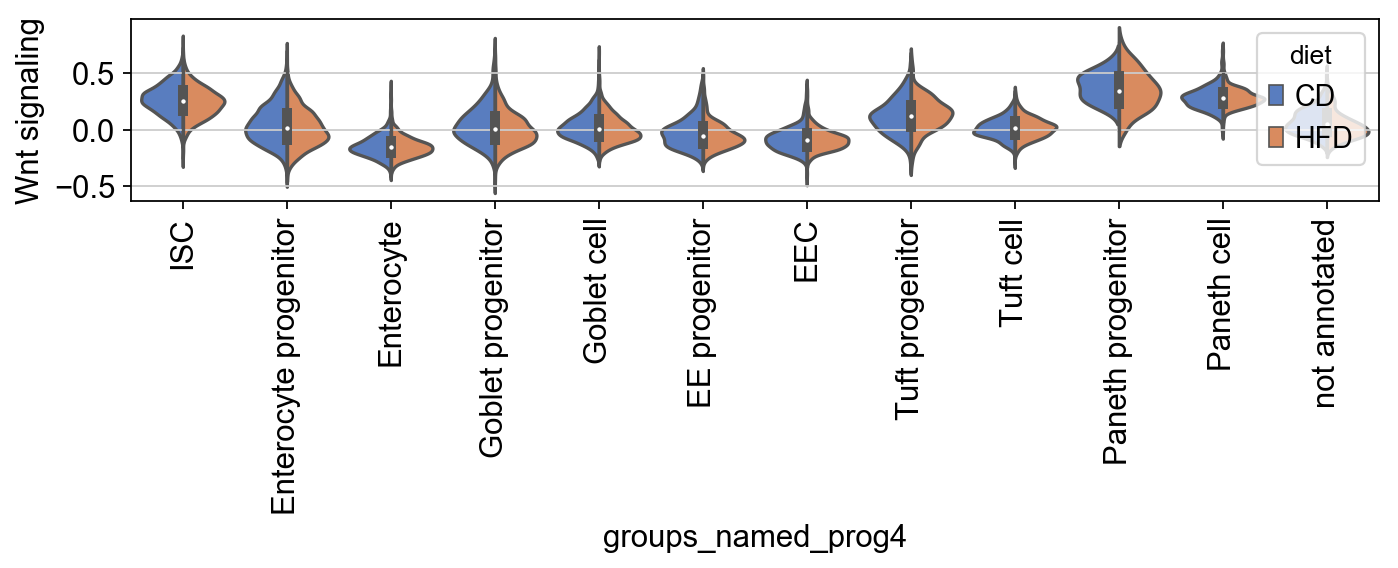

In [8]:
rcParams['figure.figsize'] = (10, 1.5)
sns.violinplot(x='groups_named_prog4', y='Wnt signaling', hue='diet', data=adata_all.obs, palette='muted', split=True, scale='width')
pl.xticks(rotation=90)
pl.show()

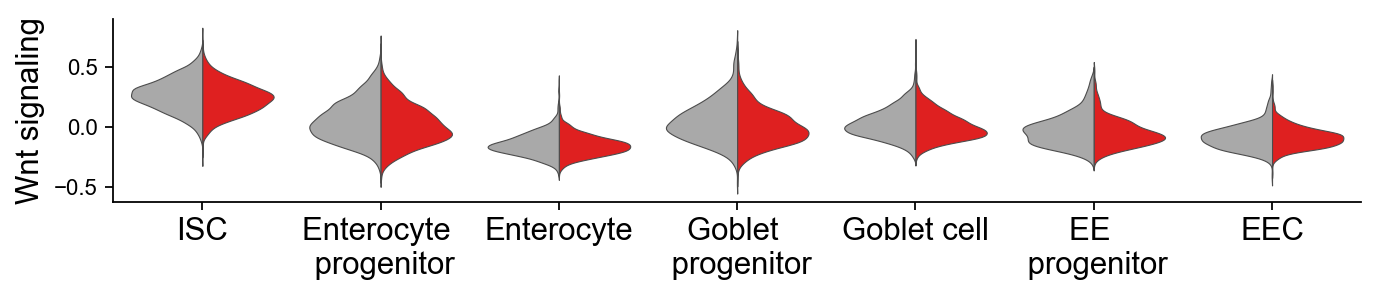

In [9]:
cats=['ISC', 'Enterocyte progenitor', 'Enterocyte', 'Goblet progenitor', 'Goblet cell', 'EE progenitor', 'EEC']
cats_names=['ISC', 'Enterocyte \n progenitor', 'Enterocyte', 'Goblet \n progenitor', 'Goblet cell', 'EE \n progenitor', 'EEC']

adata_sub = adata_all[adata_all.obs.groups_named_prog4.isin(cats)].copy()
adata_sub.obs['groups_named_prog4'].cat.remove_unused_categories()


rcParams['figure.figsize'] = (10, 1.5)
_, ax = pl.subplots()

sns.violinplot(x='groups_named_prog4', y='Wnt signaling', hue='diet', data=adata_sub.obs.copy(), 
               split=True, scale='width', palette=['darkgrey','red'], ax=ax, linewidth=0.5, inner=None)

ax.legend_.remove()
ax.set_xticklabels(cats_names)

ax.yaxis.label.set_size(14)
ax.grid(False)
#ax.set_ylim([0,1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='y', which='major', labelsize=10)
ax.set_xlabel('')

#pl.savefig('./figures/2F_violin_regionality.pdf",dpi=300,format=pdf')
pl.show()

In [10]:
sc.set_figure_params(vector_friendly=True, color_map='RdBu_r', dpi_save=300)

## Differential expression custom plots

For differential expression testing see differential expression notebook

### Volcano plots proximal ISCs and Enterocytes

In [11]:
def plot_volcano_top10(data, x, y, lfcthr, pthr, xax=None, yax=None,
                     data_point_size=50):
       
    fig, ax = pl.subplots()
    if xax is not None:
        ax.set_xlim(xax)
    if yax is not None:
        ax.set_ylim(yax)

    ### upregulated genes
    ix_up=data[x]>0
    data_up=data[ix_up]
    ix_fc=data_up[x]>lfcthr
    ix_p=data_up[y]>pthr
    
    ix_genes=[a and b for a, b in zip(ix_fc,ix_p)] 
    col1=['black' if value else 'grey' for value in ix_genes]   
    
    # plot
    ax.scatter(data=data_up,x=x, y=y,  s=data_point_size,c=col1,rasterized=True,marker='o',alpha=.3) #scatter_kws={'c':DF_0['color']}
    
    ### annotate top 10 genes
    data_up=data_up[ix_genes]
    data_up.sort_values(by=y,inplace=True,ascending=False)
    data_up=data_up[0:10]
    # change marker color and size
    ax.scatter(data=data_up, x=x, y=y, s=data_point_size+10, c='red', rasterized=True, marker='o', alpha=.3)

    ### down regulated genes
    ix_down=data[x]<0
    data_down=data[ix_down]
    ix_fc=data_down[x]< -lfcthr
    ix_p=data_down[y]>pthr
    
    ix_genes=[a and b for a, b in zip(ix_fc,ix_p)] 
    col2=['black' if value else 'grey' for value in ix_genes]
    
    # plot
    ax.scatter(data=data_down,x=x, y=y,  s=data_point_size,c=col2,rasterized=True,marker='o',alpha=.3) #scatter_kws={'c':DF_0['color']}
    ax.axhline(pthr,c='red',linestyle=':',linewidth=1)
    
    ### annotate top 5 genes
    data_down=data_down[ix_genes]
    data_down.sort_values(by=y,inplace=True,ascending=False)
    data_down=data_down[0:5]
    # change marker color and size
    ax.scatter(data=data_down, x=x, y=y, s=data_point_size+10, c='red', rasterized=True, marker='o', alpha=.3)
    
    
    ### add lines add significance thresholds
    yax=ax.get_ylim()
    ax.axvline(lfcthr,c='red',linestyle=':',linewidth=1,ymin=(0-yax[0])/(yax[1]-yax[0]))  ### set start to 0
    ax.axvline(-lfcthr,c='red',linestyle=':',linewidth=1,ymin=(0-yax[0])/(yax[1]-yax[0]))  ### set start to 0
    
    ### add axes labels
    ax.set_xlabel('log2 foldchange',fontdict={'fontsize':16})
    ax.set_ylabel('-log10(q-value)',fontdict={'fontsize':16})
    return(ax,data_up,data_down)

In [12]:
from xlrd import XLRDError
filename = './differential_expression/Supplementary Table 8.xlsx'

In [13]:
x='logFC'
y='log_p'

#### ISC proximal

In [22]:
genes_ambient= [
    'Defa24', 'Gm15284', 'Lyz1', 'Gm14851', 'Itln1', 'Defa17',
    'AY761184', 'Gm14850', 'Defa20', 'Clps', 'Gm7861', 'Spink4',
    'Ang4', 'Defa22', 'Defa26', 'Defa21', 'Fabp2', 'Gm21002', 'Defa23',
    'Defa-rs1', 'Gm15308', 'Defa3', 'Zg16', 'Agr2', 'Tff3', 'Reg4',
    'Ccl6', 'Defa5', 'Mptx2', 'Fcgbp', 'Tmsb10','Ifitm3', 'H2afv', 
    'Zfos1', 'Smim24', 'Plac8', 'Oat', 'Fth1', 'Aldob'
]

In [23]:
### prepare data
group = 'ISC (proximal)'

# transform p-values
df1 = pd.read_excel(filename, sheet_name = group, index_col=0)
df1['log_p'] = np.log10(df1['adj.P.Val'].values)
df1['log_p'][np.isneginf(df1['log_p'])] = min(df1['log_p'][np.invert(np.isneginf(df1['log_p']))])-1
df1['log_p'] = abs(df1['log_p'])

# exclude ambient genes
ix = np.isin(df1.index, genes_ambient)
df1 = df1[np.invert(ix)]

/Users/sophie/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


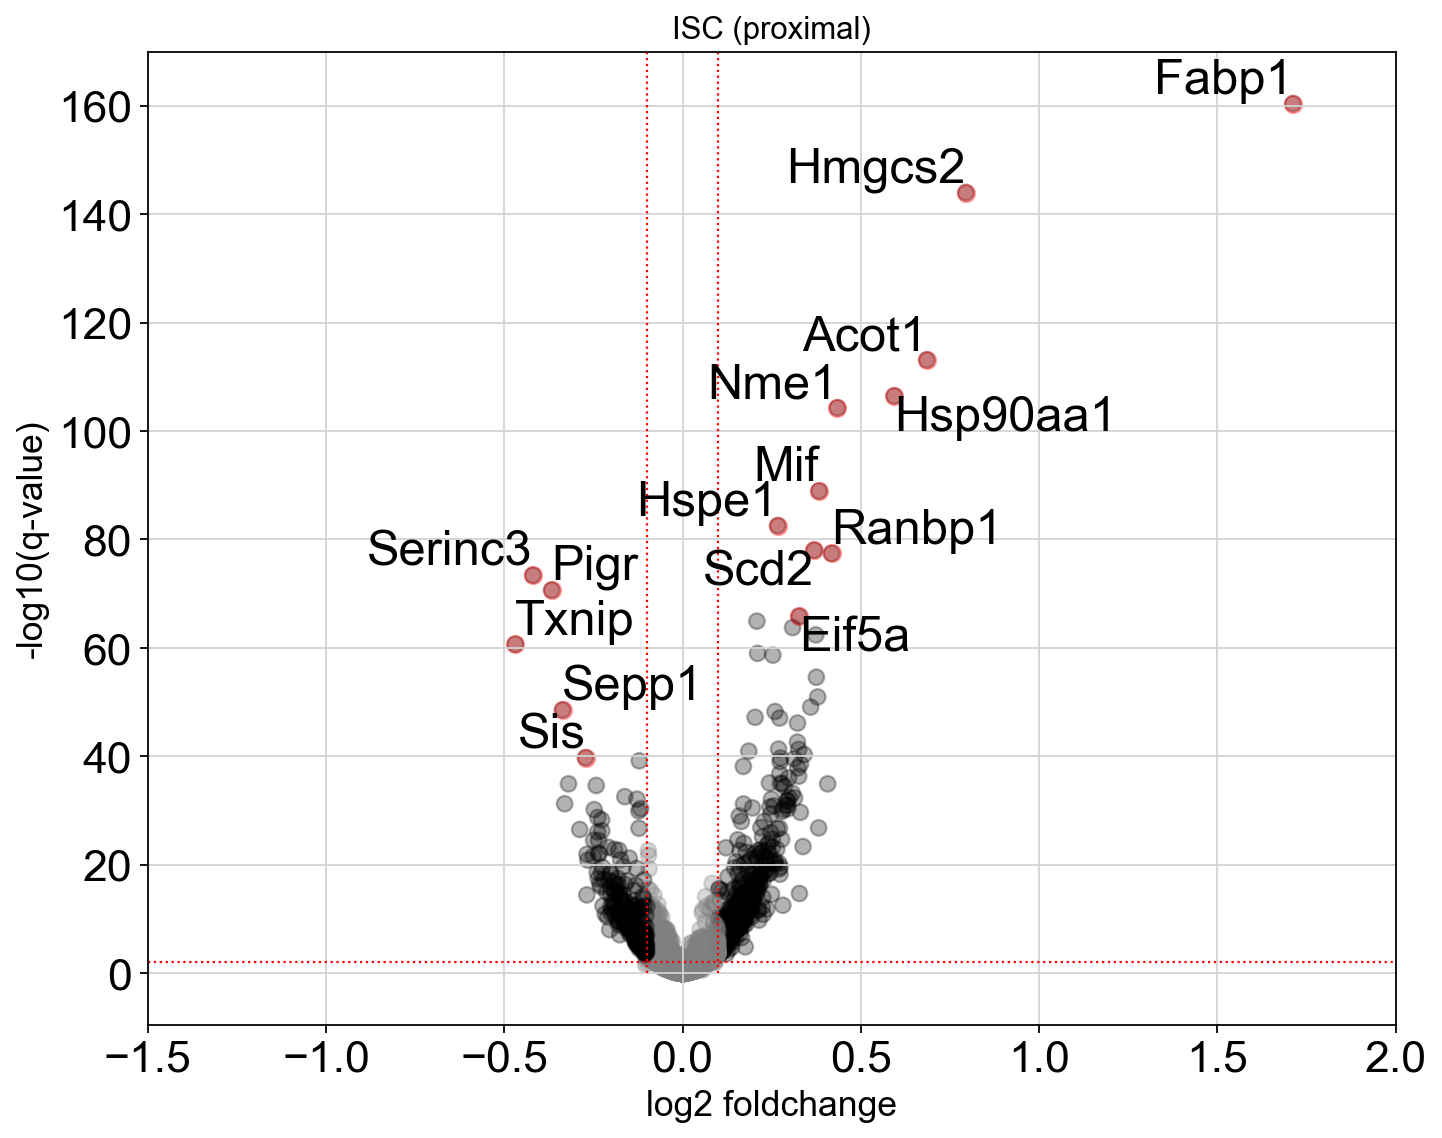

In [24]:
rcParams['figure.figsize'] = (10,8)

# volcano plot
ax, data_up, data_down = plot_volcano_top10(df1, x, y, 0.1, 2, data_point_size=50, xax=[-1.5,2], yax=None)

# manually adapt label positions
for label, xa, ya in zip(data_down.index, data_down[x], data_down[y]):        
    if (label=='Rpl41') | (label=='Pigr') | (label=='Sepp1') | (label=='Txnip'):
        ax.annotate(label,xy=(xa, ya), xytext=(-0.1, 0.1),textcoords='offset points', ha='left', va='bottom',fontsize=22,fontname='Arial')
    else:
        ax.annotate(label,xy=(xa, ya), xytext=(-0.1, 0.1),textcoords='offset points', ha='right', va='bottom',fontsize=22,fontname='Arial')  
    
for label, xa, ya in zip(data_up.index,data_up[x], data_up[y]):        
    if (label=='Ranbp1'):
        ax.annotate(label,xy=(xa, ya), xytext=(-0.1, 0.1),textcoords='offset points', ha='left', va='bottom',fontsize=22,fontname='Arial') 
    elif (label=='Scd2'):
        ax.annotate(label,xy=(xa, ya), xytext=(-0.1, 0.1),textcoords='offset points', ha='right', va='top',fontsize=22,fontname='Arial') 
    elif (label=='Hsp90aa1') | (label=='Eif5a'):
        ax.annotate(label,xy=(xa, ya), xytext=(-0.1, 0.1),textcoords='offset points', ha='left', va='top',fontsize=22,fontname='Arial')
    else:
        ax.annotate(label,xy=(xa, ya), xytext=(-0.1, 0.1),textcoords='offset points', ha='right', va='bottom',fontsize=22,fontname='Arial')

pl.title(group)
pl.setp(ax.get_xticklabels(), fontsize=20)
pl.setp(ax.get_yticklabels(), fontsize=20)
pl.grid(which='major',color='lightgrey')

pl.savefig('./figures/5_Volcano_ISC.pdf', dpi=300, format='pdf')
pl.show()

#### EP proximal

In [25]:
### prepare data
group = 'Enterocyte progenitor (pr'

# transform p-values
df1 = pd.read_excel(filename, sheet_name = group, index_col=0)
df1['log_p'] = np.log10(df1['adj.P.Val'].values)
df1['log_p'][np.isneginf(df1['log_p'])] = min(df1['log_p'][np.invert(np.isneginf(df1['log_p']))])-1
df1['log_p'] = abs(df1['log_p'])

# exclude ambient genes
ix = np.isin(df1.index,genes_ambient)
df1 = df1[np.invert(ix)]

/Users/sophie/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


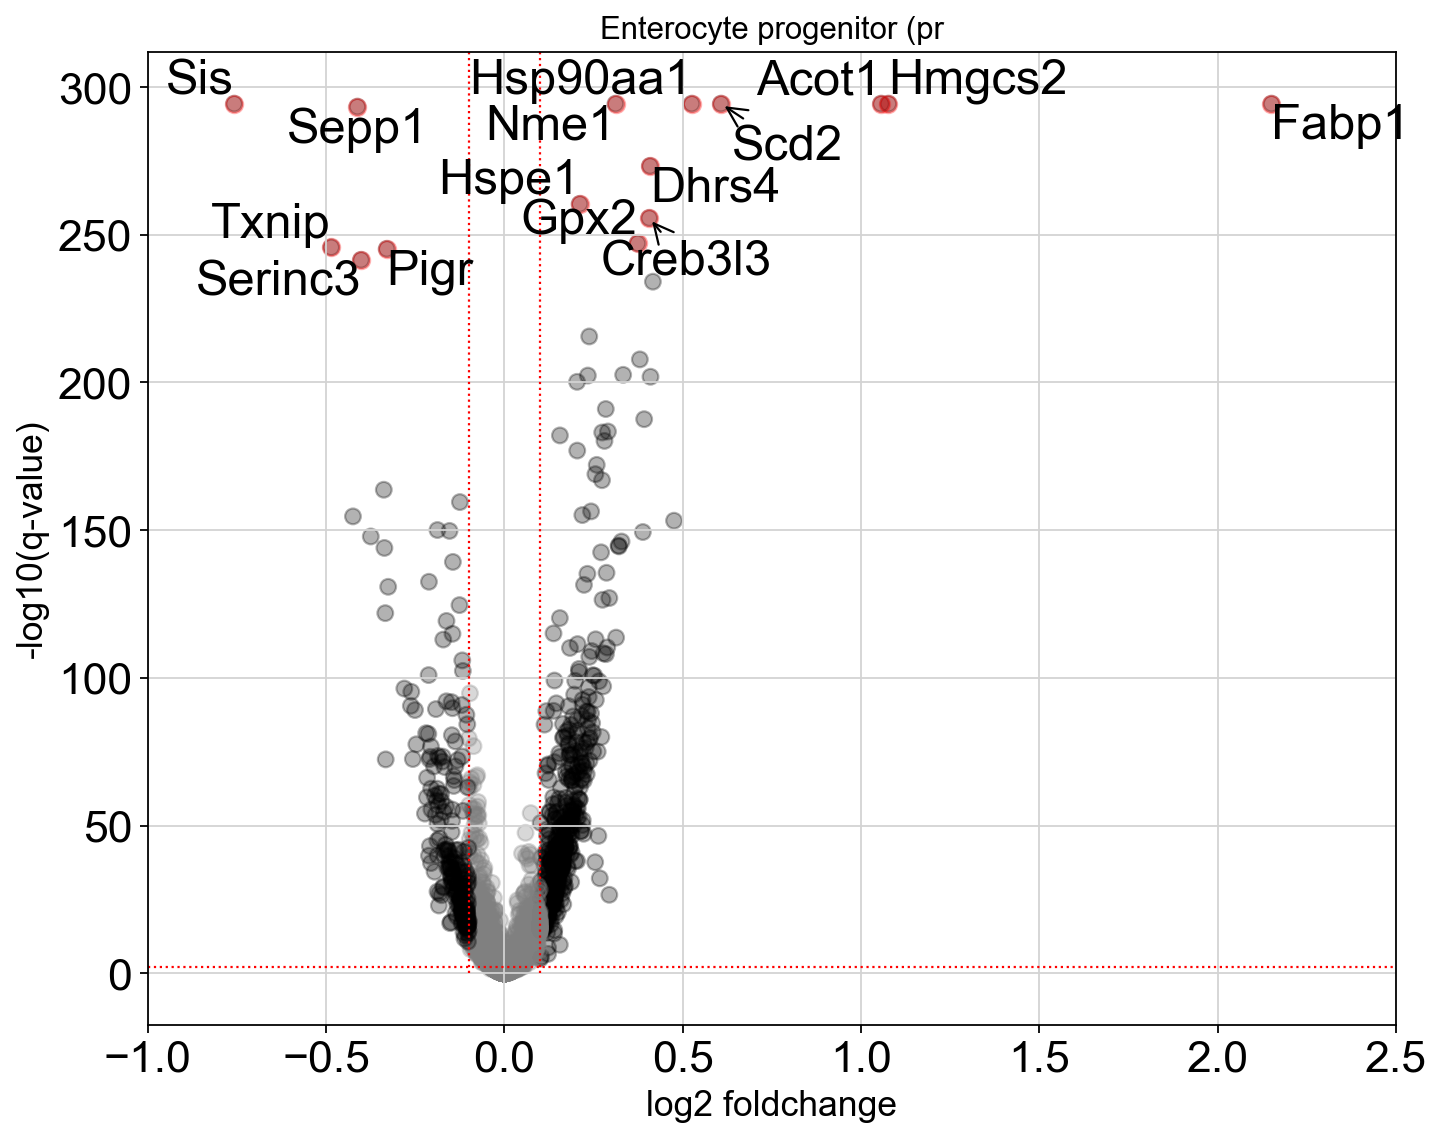

In [26]:
rcParams['figure.figsize'] = (10,8)

# volcano plot
ax, data_up, data_down = plot_volcano_top10(df1, x, y, 0.1, 2, data_point_size=50, xax=[-1, 2.5], yax=None)

# manually adapt label positions
for label, xa, ya in zip(data_down.index, data_down[x], data_down[y]):        
    if (label=='Pigr')| (label=='Oat'):
        ax.annotate(label,xy=(xa, ya), xytext=(-0.1, 0.1),textcoords='offset points', ha='left', va='top',fontsize=22,fontname='Arial') 
    elif (label=='Serinc3')  | (label=='Smim24'):
        ax.annotate(label,xy=(xa, ya), xytext=(-0.1, 0.1),textcoords='offset points', ha='right', va='top',fontsize=22,fontname='Arial')
    elif (label=='Sepp1'):
        ax.annotate(label,xy=(xa, ya), xytext=(-0.1, 0.1),textcoords='offset points', ha='center', va='top',fontsize=22,fontname='Arial') 
    else:
        ax.annotate(label,xy=(xa, ya), xytext=(-0.1, 0.1),textcoords='offset points', ha='right', va='bottom',fontsize=22,fontname='Arial') 
    
for label, xa, ya in zip(data_up.index,data_up[x], data_up[y]):        
    if (label=='Dhrs4') |(label=='Fabp1'):
        ax.annotate(label,xy=(xa, ya), xytext=(-0.1, 0.1),textcoords='offset points', ha='left', va='top',fontsize=22,fontname='Arial') 
    elif (label=='Hmgcs2'):
        ax.annotate(label,xy=(xa, ya), xytext=(-0.1, 0.1),textcoords='offset points', ha='left', va='bottom',fontsize=22,fontname='Arial') 
    elif (label=='Nme1') :
        ax.annotate(label,xy=(xa, ya), xytext=(-0.1, 0.1),textcoords='offset points', ha='right', va='top',fontsize=22,fontname='Arial')  
    elif (label=='Scd2') | (label=='Creb3l3')  :
        ax.annotate(label,xy=(xa, ya), xytext=(55, -30),textcoords='offset points', 
                    ha='right', va='bottom',fontsize=22,fontname='Arial',arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
    else:
        ax.annotate(label,xy=(xa, ya), xytext=(-0.1, 0.1),textcoords='offset points', ha='right', va='bottom',fontsize=22,fontname='Arial')  

pl.title(group)
pl.setp(ax.get_xticklabels(), fontsize=20)
pl.setp(ax.get_yticklabels(), fontsize=20)
pl.grid(which='major',color='lightgrey')

pl.savefig('./figures/5_Volcano_EP.pdf', dpi=300, format='pdf')
pl.show()

#### Enterocyte proximal

In [27]:
genes_ambient= [
    'Defa24', 'Gm15284', 'Lyz1', 'Gm14851', 'Itln1', 'Defa17',
    'AY761184', 'Gm14850', 'Defa20', 'Clps', 'Gm7861', 'Spink4',
    'Ang4', 'Defa22', 'Defa26', 'Defa21', 'Gm21002', 'Defa23',
    'Defa-rs1', 'Gm15308', 'Defa3', 'Zg16', 'Agr2', 'Tff3', 'Reg4',
    'Ccl6', 'Defa5', 'Mptx2', 'Fcgbp', 'Tmsb10','Ifitm3', 'H2afv', 
    'Zfos1', 'Smim24', 'Plac8', 'Oat', 'Fth1', 'Aldob'
]
# Fabp2 shows above ambient differences and thus included

In [28]:
### prepare data
group = 'Enterocyte (proximal)'

# transform p-values
df1 = pd.read_excel(filename, sheet_name = group, index_col=0)
df1['log_p'] = np.log10(df1['adj.P.Val'].values)
df1['log_p'][np.isneginf(df1['log_p'])] = min(df1['log_p'][np.invert(np.isneginf(df1['log_p']))])-1
df1['log_p'] = abs(df1['log_p'])

# exclude ambient genes
ix = np.isin(df1.index,genes_ambient)
df1 = df1[np.invert(ix)]

/Users/sophie/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


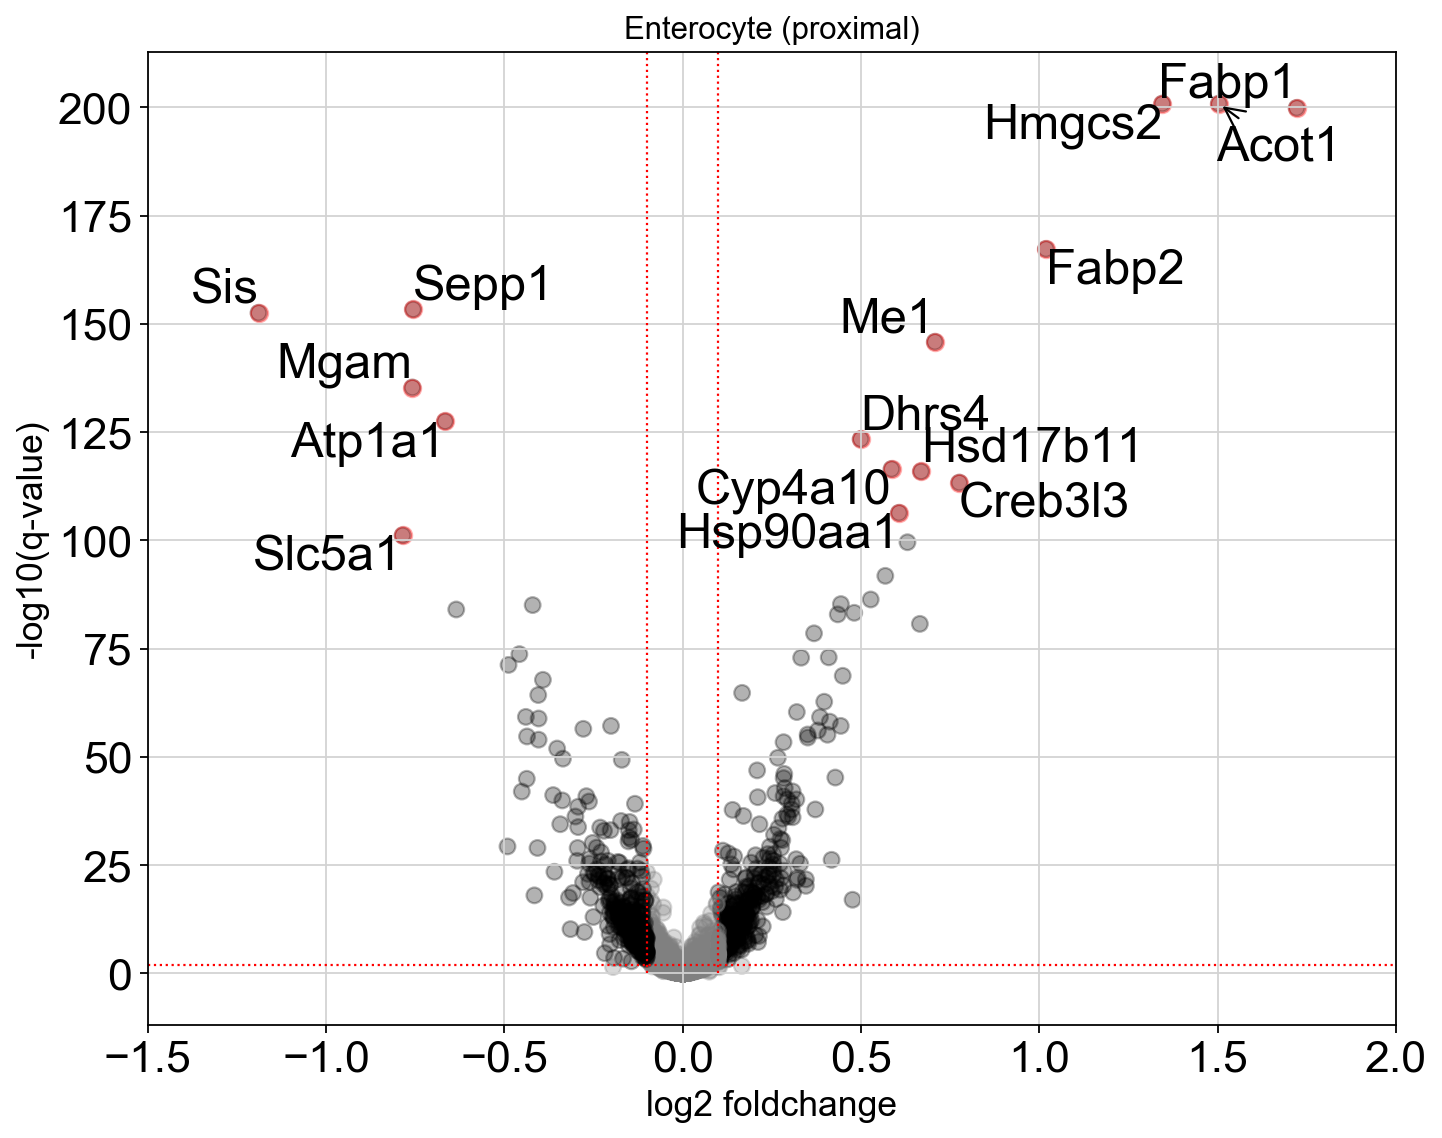

In [29]:
rcParams['figure.figsize'] = (10,8)

# volcano plot
ax, data_up, data_down = plot_volcano_top10(df1, x, y, 0.1, 2, data_point_size=50, xax=[-1.5,2], yax=None)

# manually adapt label positions
for label, xa, ya in zip(data_down.index,data_down[x], data_down[y]):        
    if (label=='Pigr')| (label=='Oat'):
        ax.annotate(label,xy=(xa, ya), xytext=(-0.1, 0.1),textcoords='offset points', ha='left', va='top',fontsize=22,fontname='Arial')
    elif (label=='Khk')  | (label=='Slc5a1')|(label=='Atp1a1'):
        ax.annotate(label,xy=(xa, ya), xytext=(-0.1, 0.1),textcoords='offset points', ha='right', va='top',fontsize=22,fontname='Arial')   
    elif (label=='Atp1b1')| (label=='Sepp1'):
        ax.annotate(label,xy=(xa, ya), xytext=(-0.1, 0.1),textcoords='offset points', ha='left', va='bottom',fontsize=22,fontname='Arial')  
    else:
        ax.annotate(label,xy=(xa, ya), xytext=(-0.1, 0.1),textcoords='offset points', ha='right', va='bottom',fontsize=22,fontname='Arial')
    
for label, xa, ya in zip(data_up.index,data_up[x], data_up[y]):        
    if (label=='Creb3l3')|(label=='Fabp2'):
        ax.annotate(label,xy=(xa, ya), xytext=(-0.1, 0.1),textcoords='offset points', ha='left', va='top',fontsize=22,fontname='Arial') 
    elif (label=='Hmgcs2')|(label=='Hsp90aa1')|(label=='Cyp4a10') :
        ax.annotate(label,xy=(xa, ya), xytext=(-0.1, 0.1),textcoords='offset points', ha='right', va='top',fontsize=22,fontname='Arial') 
    elif (label=='Dhrs4')  | (label=='Hsd17b11'):
        ax.annotate(label,xy=(xa, ya), xytext=(-0.1, 0.1),textcoords='offset points', ha='left', va='bottom',fontsize=22,fontname='Arial')   
    elif (label=='Acot1')  :
        ax.annotate(label,xy=(xa, ya), xytext=(55, -30),textcoords='offset points', 
                    ha='right', va='bottom',fontsize=22,fontname='Arial',arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
    else:
        ax.annotate(label,xy=(xa, ya), xytext=(-0.1, 0.1),textcoords='offset points', ha='right', va='bottom',fontsize=22,fontname='Arial') 

pl.title(group)
pl.setp(ax.get_xticklabels(), fontsize=20)
pl.setp(ax.get_yticklabels(), fontsize=20)
pl.grid(which='major',color='lightgrey')

pl.savefig('./figures/5_Volcano_Enterocyte.pdf', dpi=300, format='pdf')
pl.show()

### Selected enriched pathways in proximal ISCs and Enterocytes

In [30]:
filename = './differential_expression/Supplementary Table 9.xlsx'

In [31]:
term_up = ['PPAR signaling pathway_Homo sapiens_hsa03320',
           'Biosynthesis of unsaturated fatty acids_Homo sapiens_hsa01040',
           'Fatty acid elongation_Homo sapiens_hsa00062',
           'Fat digestion and absorption_Homo sapiens_hsa04975',
           'Fatty acid metabolism_Homo sapiens_hsa01212',
           'Fatty acid degradation_Homo sapiens_hsa00071']

In [32]:
term_down = ['Galactose metabolism_Homo sapiens_hsa00052',
             'Fructose and mannose metabolism_Homo sapiens_hsa00051',
             'Glycolysis / Gluconeogenesis_Homo sapiens_hsa00010',
             'Carbohydrate digestion and absorption_Homo sapiens_hsa04973',]

In [33]:
df1_isc = pd.read_excel(filename, sheet_name='ISC (proximal)_up').set_index(['Term'])
df2_isc = pd.read_excel(filename, sheet_name='ISC (proximal)_down').set_index(['Term'])
df1_ep = pd.read_excel(filename, sheet_name='Enterocyte progenitor (pr_up').set_index(['Term'])
df2_ep = pd.read_excel(filename, sheet_name='Enterocyte progenitor (pr_down').set_index(['Term'])
df1_e = pd.read_excel(filename, sheet_name='Enterocyte (proximal)_up').set_index(['Term'])
df2_e = pd.read_excel(filename, sheet_name='Enterocyte (proximal)_down').set_index(['Term'])

In [34]:
y1_isc = df1_isc.loc[term_up]['Z-score'].copy()
y1_isc=abs(y1_isc)

y1_ep = df1_ep.loc[term_up]['Z-score'].copy()
y1_ep=abs(y1_ep)

y1_e = df1_e.loc[term_up]['Z-score'].copy()
y1_e=abs(y1_e)


y2_isc=df2_isc.loc[term_down]['Z-score'].copy()
y2_isc.loc[y2_isc>0]=0 # set positive score to 0 for plotting

y2_ep = df2_ep.loc[term_down]['Z-score'].copy()
y2_e = df2_e.loc[term_down]['Z-score'].copy()

In [35]:
# shorten pathway names
y1_name=[s.split('_')[0] for s in term_up]
y2_name=[s.split('_')[0] for s in term_down]

In [36]:
# y-positions for plotting

y = []
for l,i in enumerate(range(31, 25, -1)):
    y.extend(list([i+(7-l)*6]))
    
y2 = [n+1 for n in y]
y3 = [n+2 for n in y]
x = y+y2+y3

y = []
for l,i in enumerate(range(0,4)):
   
    y.extend([i+l*6])
    
y2 = [n+1 for n in y]
y3 = [n+2 for n in y]
x2 = y+y2+y3

x_all = []
x_all = x+x2

In [37]:
# prepare x-values
y = np.concatenate((y1_isc.values, y1_ep.values, y1_e.values, y2_isc.values, y2_ep.values, y2_e.values),axis=0)

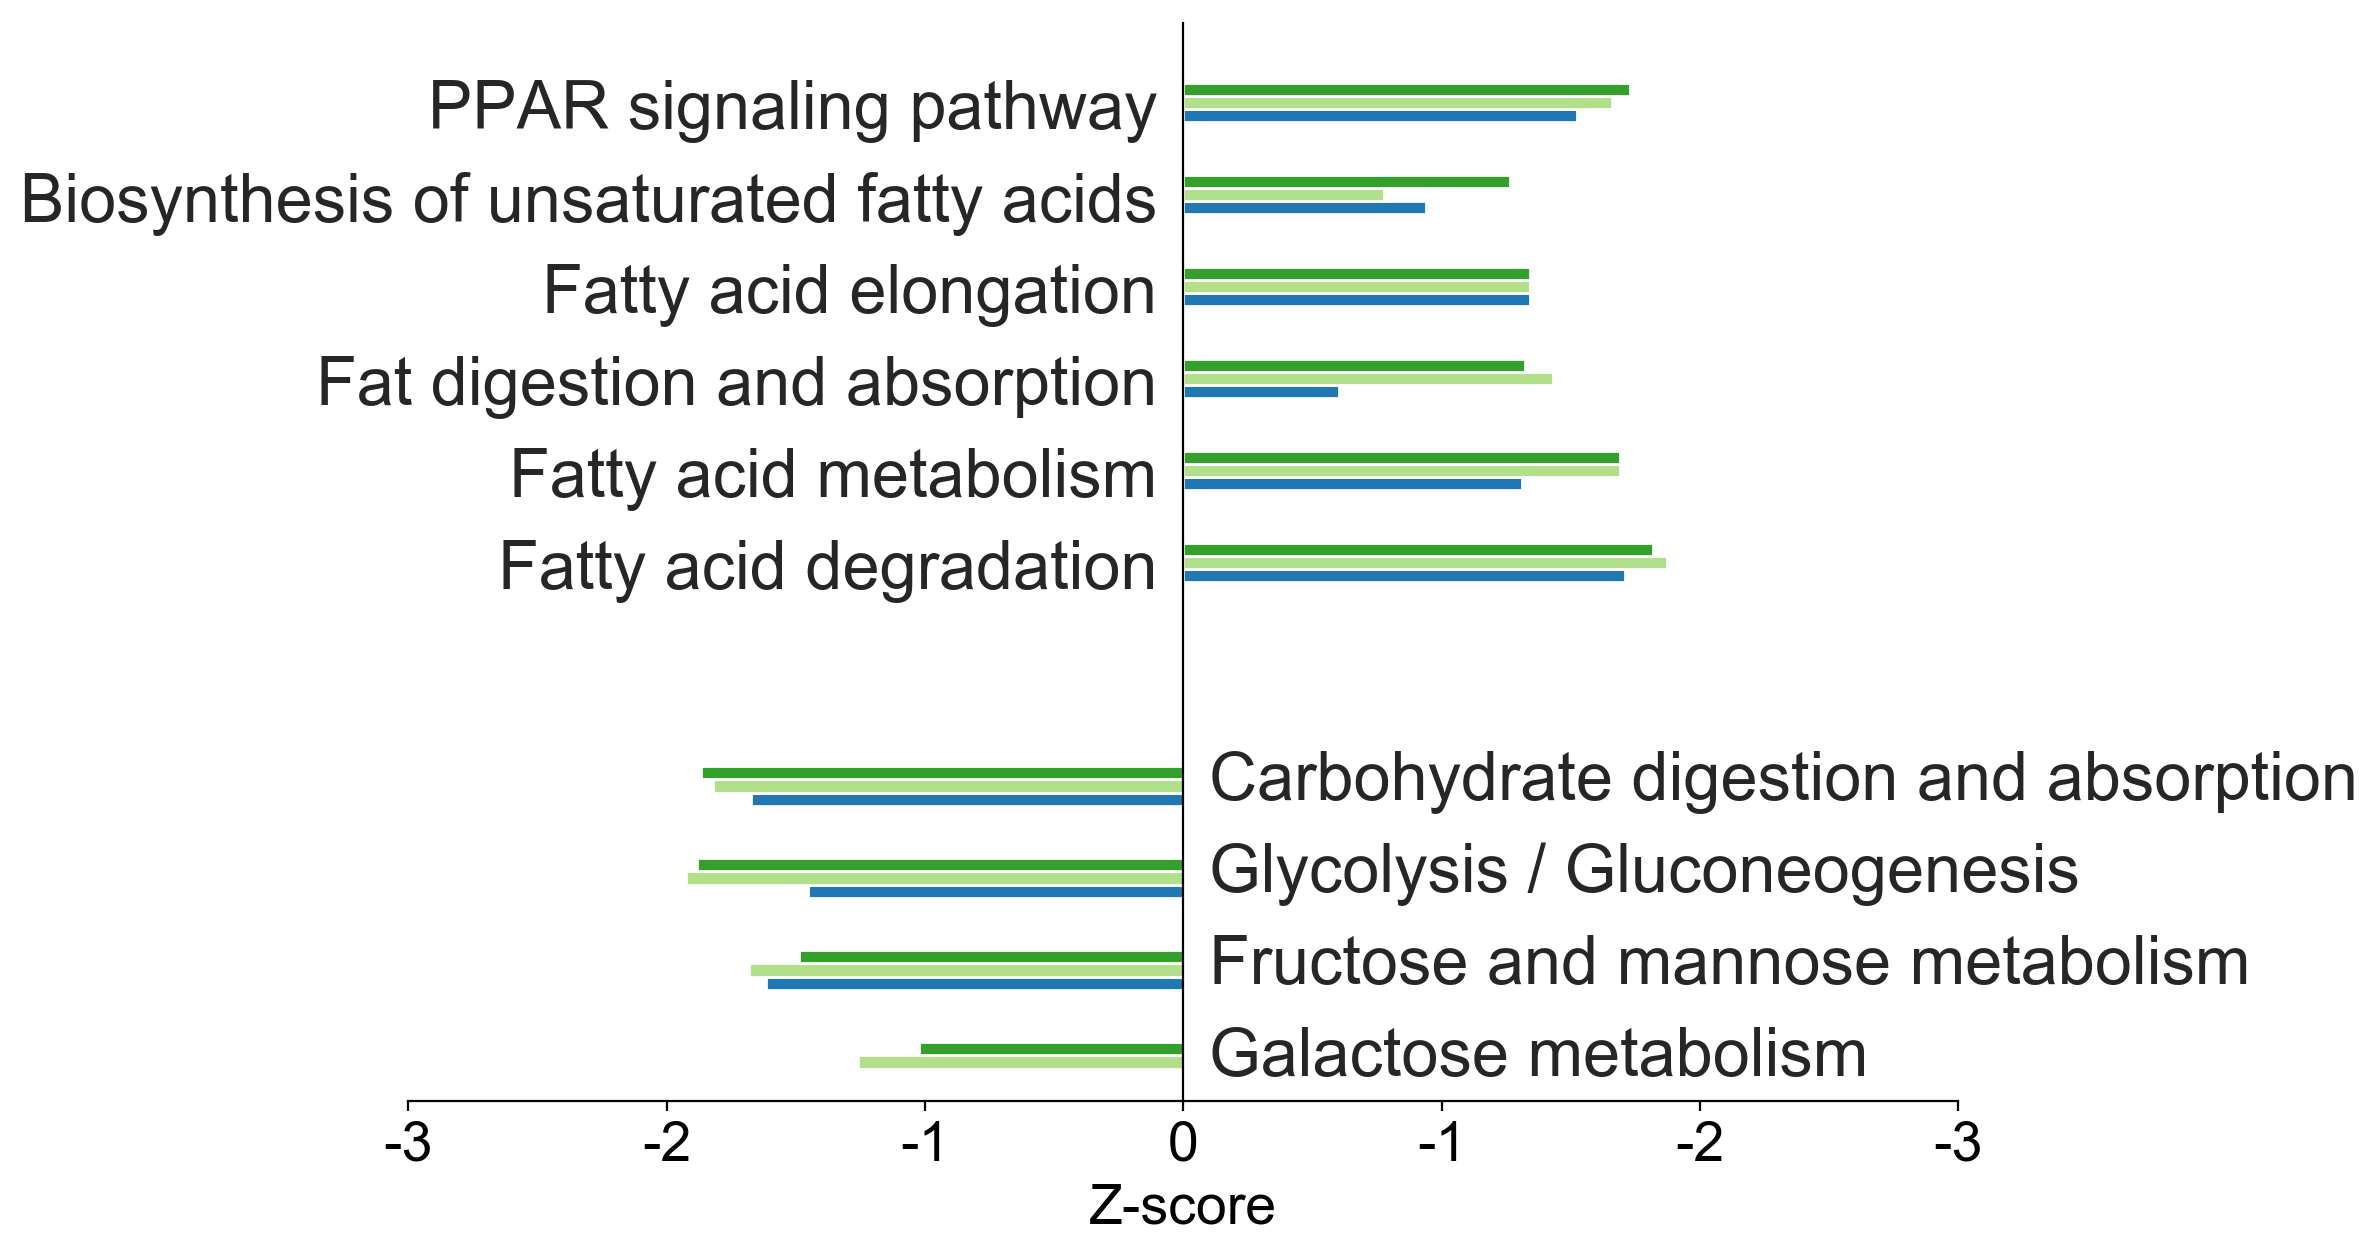

In [38]:
pl.rcParams.update(pl.rcParamsDefault)
rcParams['figure.figsize'] = (10, 7)

fig, ax = pl.subplots(ncols=1)

sns.axes_style('white')
sns.set_style('white')

colors = ['#1f78b4','#1f78b4','#1f78b4','#1f78b4','#1f78b4','#1f78b4',
          '#b2df8a','#b2df8a','#b2df8a','#b2df8a','#b2df8a','#b2df8a',
          '#33a02c', '#33a02c', '#33a02c', '#33a02c','#33a02c', '#33a02c', 
          '#1f78b4','#1f78b4','#1f78b4','#1f78b4', 
          '#b2df8a','#b2df8a','#b2df8a','#b2df8a',
          '#33a02c', '#33a02c', '#33a02c', '#33a02c']

ax.barh(x_all, y, align='center', color=colors, height=1)

# add textlabels
x2 = np.zeros(len(x_all))

for i,p in enumerate(ax.patches):   
    x2[i] = p.get_y()

for label, _y in zip(y1_name, x2[6:12]):        
    ax.text(-0.1,_y-0.2,label,
        ha='right',va='center',fontsize=24,fontname='Arial'
    )  

for label, _y in zip(y2_name, x2[26:30]):
    ax.text(0.1,_y-0.2,label,
        ha='left',va='center',fontsize=24,fontname='Arial'
    )  
    
ax.set_xlim([-3,3])    
ax.set_ylim([-2,80])    
ax.spines['left'].set_position(('data', 0.0))
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

ax.set_yticks([])
ax.set_xticklabels(['-3','-2','-1','0','-1','-2','-3'],fontsize=20)
pl.xlabel('Z-score',fontsize=20)

pl.savefig('./figures/5_KEGG_pathways.pdf', dpi=300, format='pdf')

pl.show()
pl.rcParams.update(pl.rcParamsDefault)

### Foldchanges of selected genes

load differential expression results: HFD vs. CD cells per cell type, see differential expression notebook

In [39]:
filename = './differential_expression/Supplementary Table 1.xlsx'

In [40]:
# scale for plotting
adata_all_scale = adata_all.copy()
sc.pp.scale(adata_all_scale, max_value=6, zero_center=False)

/Users/sophie/code/scanpy/scanpy/preprocessing/simple.py:1008: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)


In [41]:
cats = ['ISC', 'Enterocyte progenitor', 'Enterocyte', 'Goblet progenitor', 'Goblet cell', 'EE progenitor', 'EEC']

Ppar signaling, Fatty acid biosynthesis, Carbohydrate digestion and absorption

In [42]:
gene_names=[
    'Hmgcs2', 'Acadl', 'Acaa2', 'Ppara', 'Ppard', 'Pparg', #Ppar signaling
    'Scd2', 'Fabp1', 'Fabp2', 'Acot1', 'Acox1', 'Srebf1', 'Fads1', 'Me1', # Fatty acid biosynthesis
    'Slc2a2', 'Sis', 'Aldob', 'Khk', 'Slc5a1', 'Mgam', 'Mlxipl' # Carbohydrate digestion and absorption
]

/Users/sophie/miniconda3/lib/python3.5/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


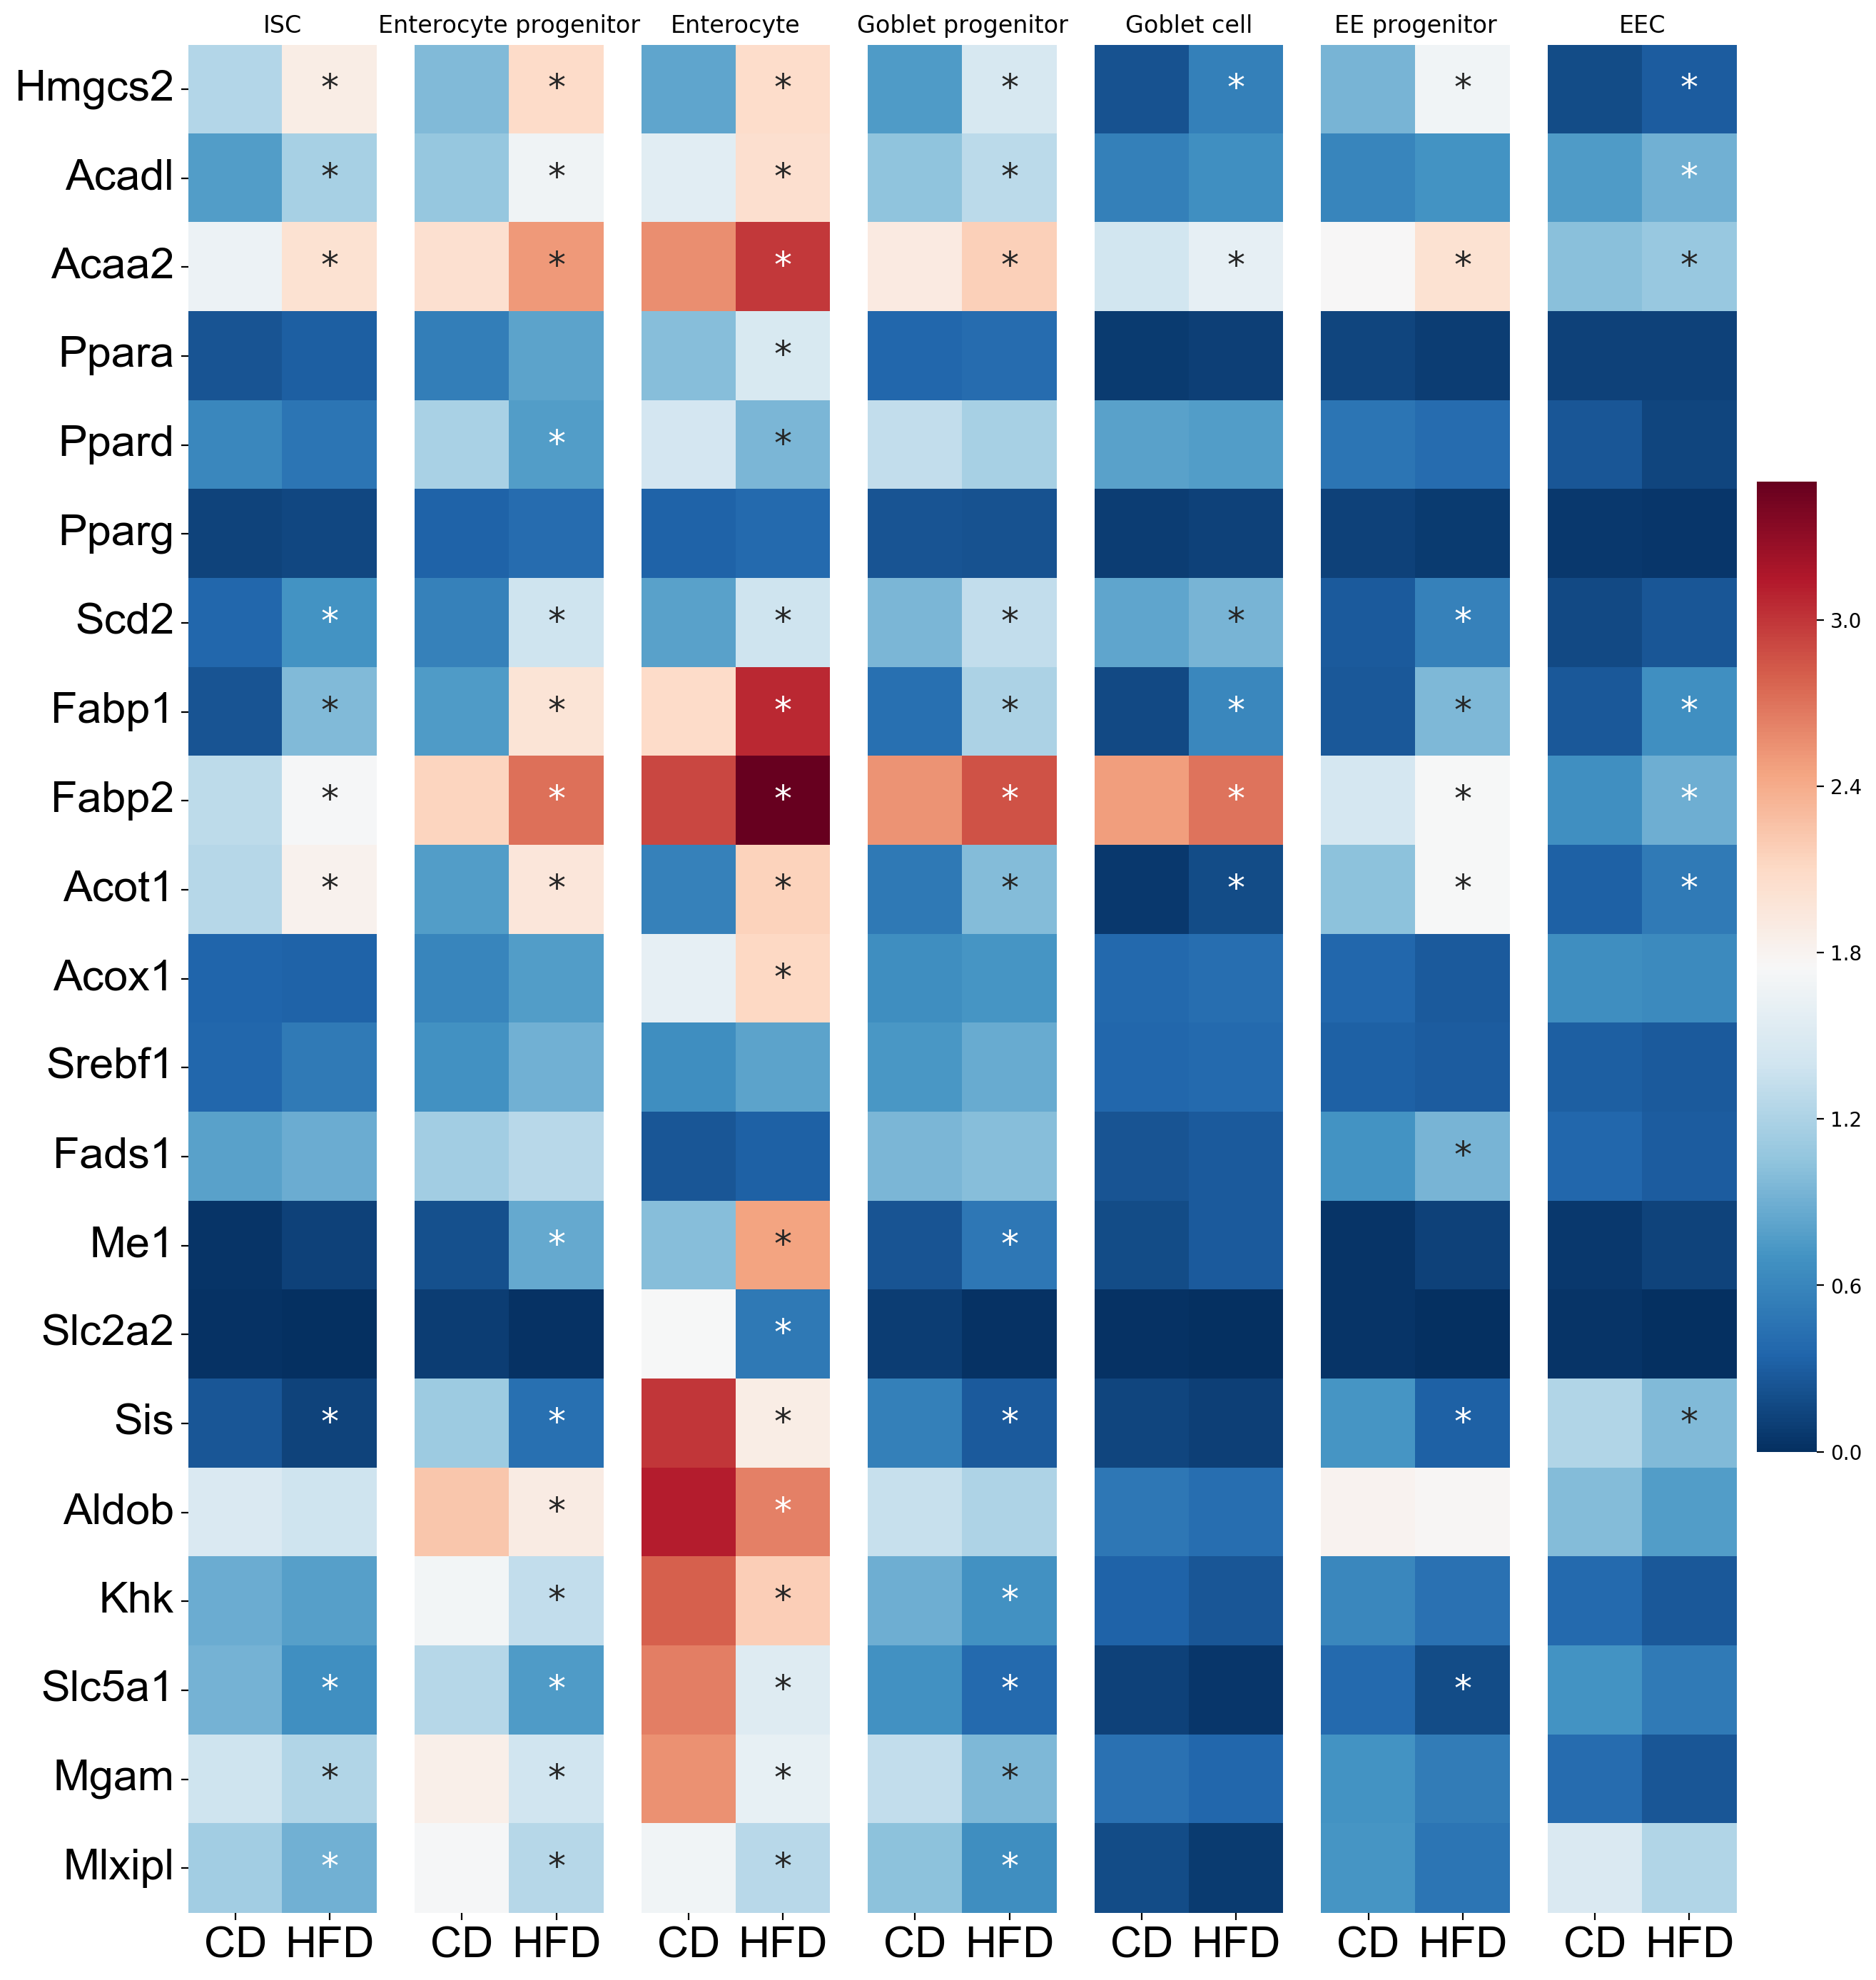

In [43]:
fig, axs = pl.subplots(ncols=len(cats), gridspec_kw={'wspace': 0.2}, figsize=(14, 17))
cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i,group in enumerate(cats):
    
    # subset cells and genes
    adata_sub = adata_all_scale[adata_all.obs['groups_named_prog4'].isin([group])].copy()
    adata_sub = adata_sub[:, gene_names].copy()

    # get mean expression per condition
    df = pd.DataFrame(adata_sub.X.toarray(), columns=adata_sub.var_names)
    df['diet'] = adata_sub.obs['diet'].values
    df_mean = df.groupby(['diet']).mean()[gene_names]

    try:   
        # upregulated genes
        data = pd.read_excel(filename, group+'_up', index_col=0)
        ix_fc = data['logFC']>0.1
        data_up = data[ix_fc]
        ix_p = data_up['adj.P.Val']<0.01
        data_up = data_up[ix_p]
        
        # downregulated genes
        data = pd.read_excel(filename, group+'_down', index_col=0)
        ix_fc = data['logFC']<-0.1
        data_down = data[ix_fc]
        ix_p = data_down['adj.P.Val']<0.01
        data_down = data_down[ix_p]
        
        genes_up = [gene for gene in gene_names if gene in data_up.index]
        genes_down = [gene for gene in gene_names if gene in data_down.index]

        annots = np.array([['','*'] if value else ['',''] for value in np.isin(df_mean.columns, genes_up+genes_down)])
        
        # plot
        sns.heatmap(df_mean.T, cmap='RdBu_r', ax=axs[i], cbar=i==0, yticklabels=i==0, cbar_ax=None if i else cbar_ax,
                    annot=annots, fmt='', vmin=0, vmax=3.5, annot_kws={'fontsize':18,'horizontalalignment':'center'})
                
        del annots
        
    except XLRDError:
        pass
    
    # plot if no significant genes
    if 'annots' not in locals():
        sns.heatmap(df_mean.T, cmap='RdBu_r', ax=axs[i], cbar=i==0, yticklabels=i==0, cbar_ax=None if i else cbar_ax, vmin=0, vmax=3.5)
    
    if i==0:
        axs[i].set_yticklabels(df_mean.columns, fontdict={'verticalalignment': 'center','rotation':0,'fontsize':22,'fontname':'Arial'})
        
    axs[i].set_title(group)
    axs[i].set_ylabel('')
    axs[i].set_xlabel('')
    axs[i].set_xticklabels(['CD','HFD'], fontdict={'rotation':0, 'fontsize':22, 'fontname':'Arial'})
    del df
    
fig.tight_layout(rect=[0, 0, .9, 1])
pl.savefig('./figures/5_heatmap.pdf', dpi=600, format='pdf')
pl.show()
pl.rcParams.update(pl.rcParamsDefault)

Wnt signaling, PI3/Akt signaling

In [44]:
gene_names=[
    'Lgr5','Ascl2','Axin2', #Wnt signaling
    'Akt1', 'Hras','Map2k2','Creb3l3','Ccnd2', 'Atf4','Hsp90aa1','Hsp90b1','Eif4e','Eif4ebp1' #PI3/Akt signaling
           ]

/Users/sophie/miniconda3/lib/python3.5/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


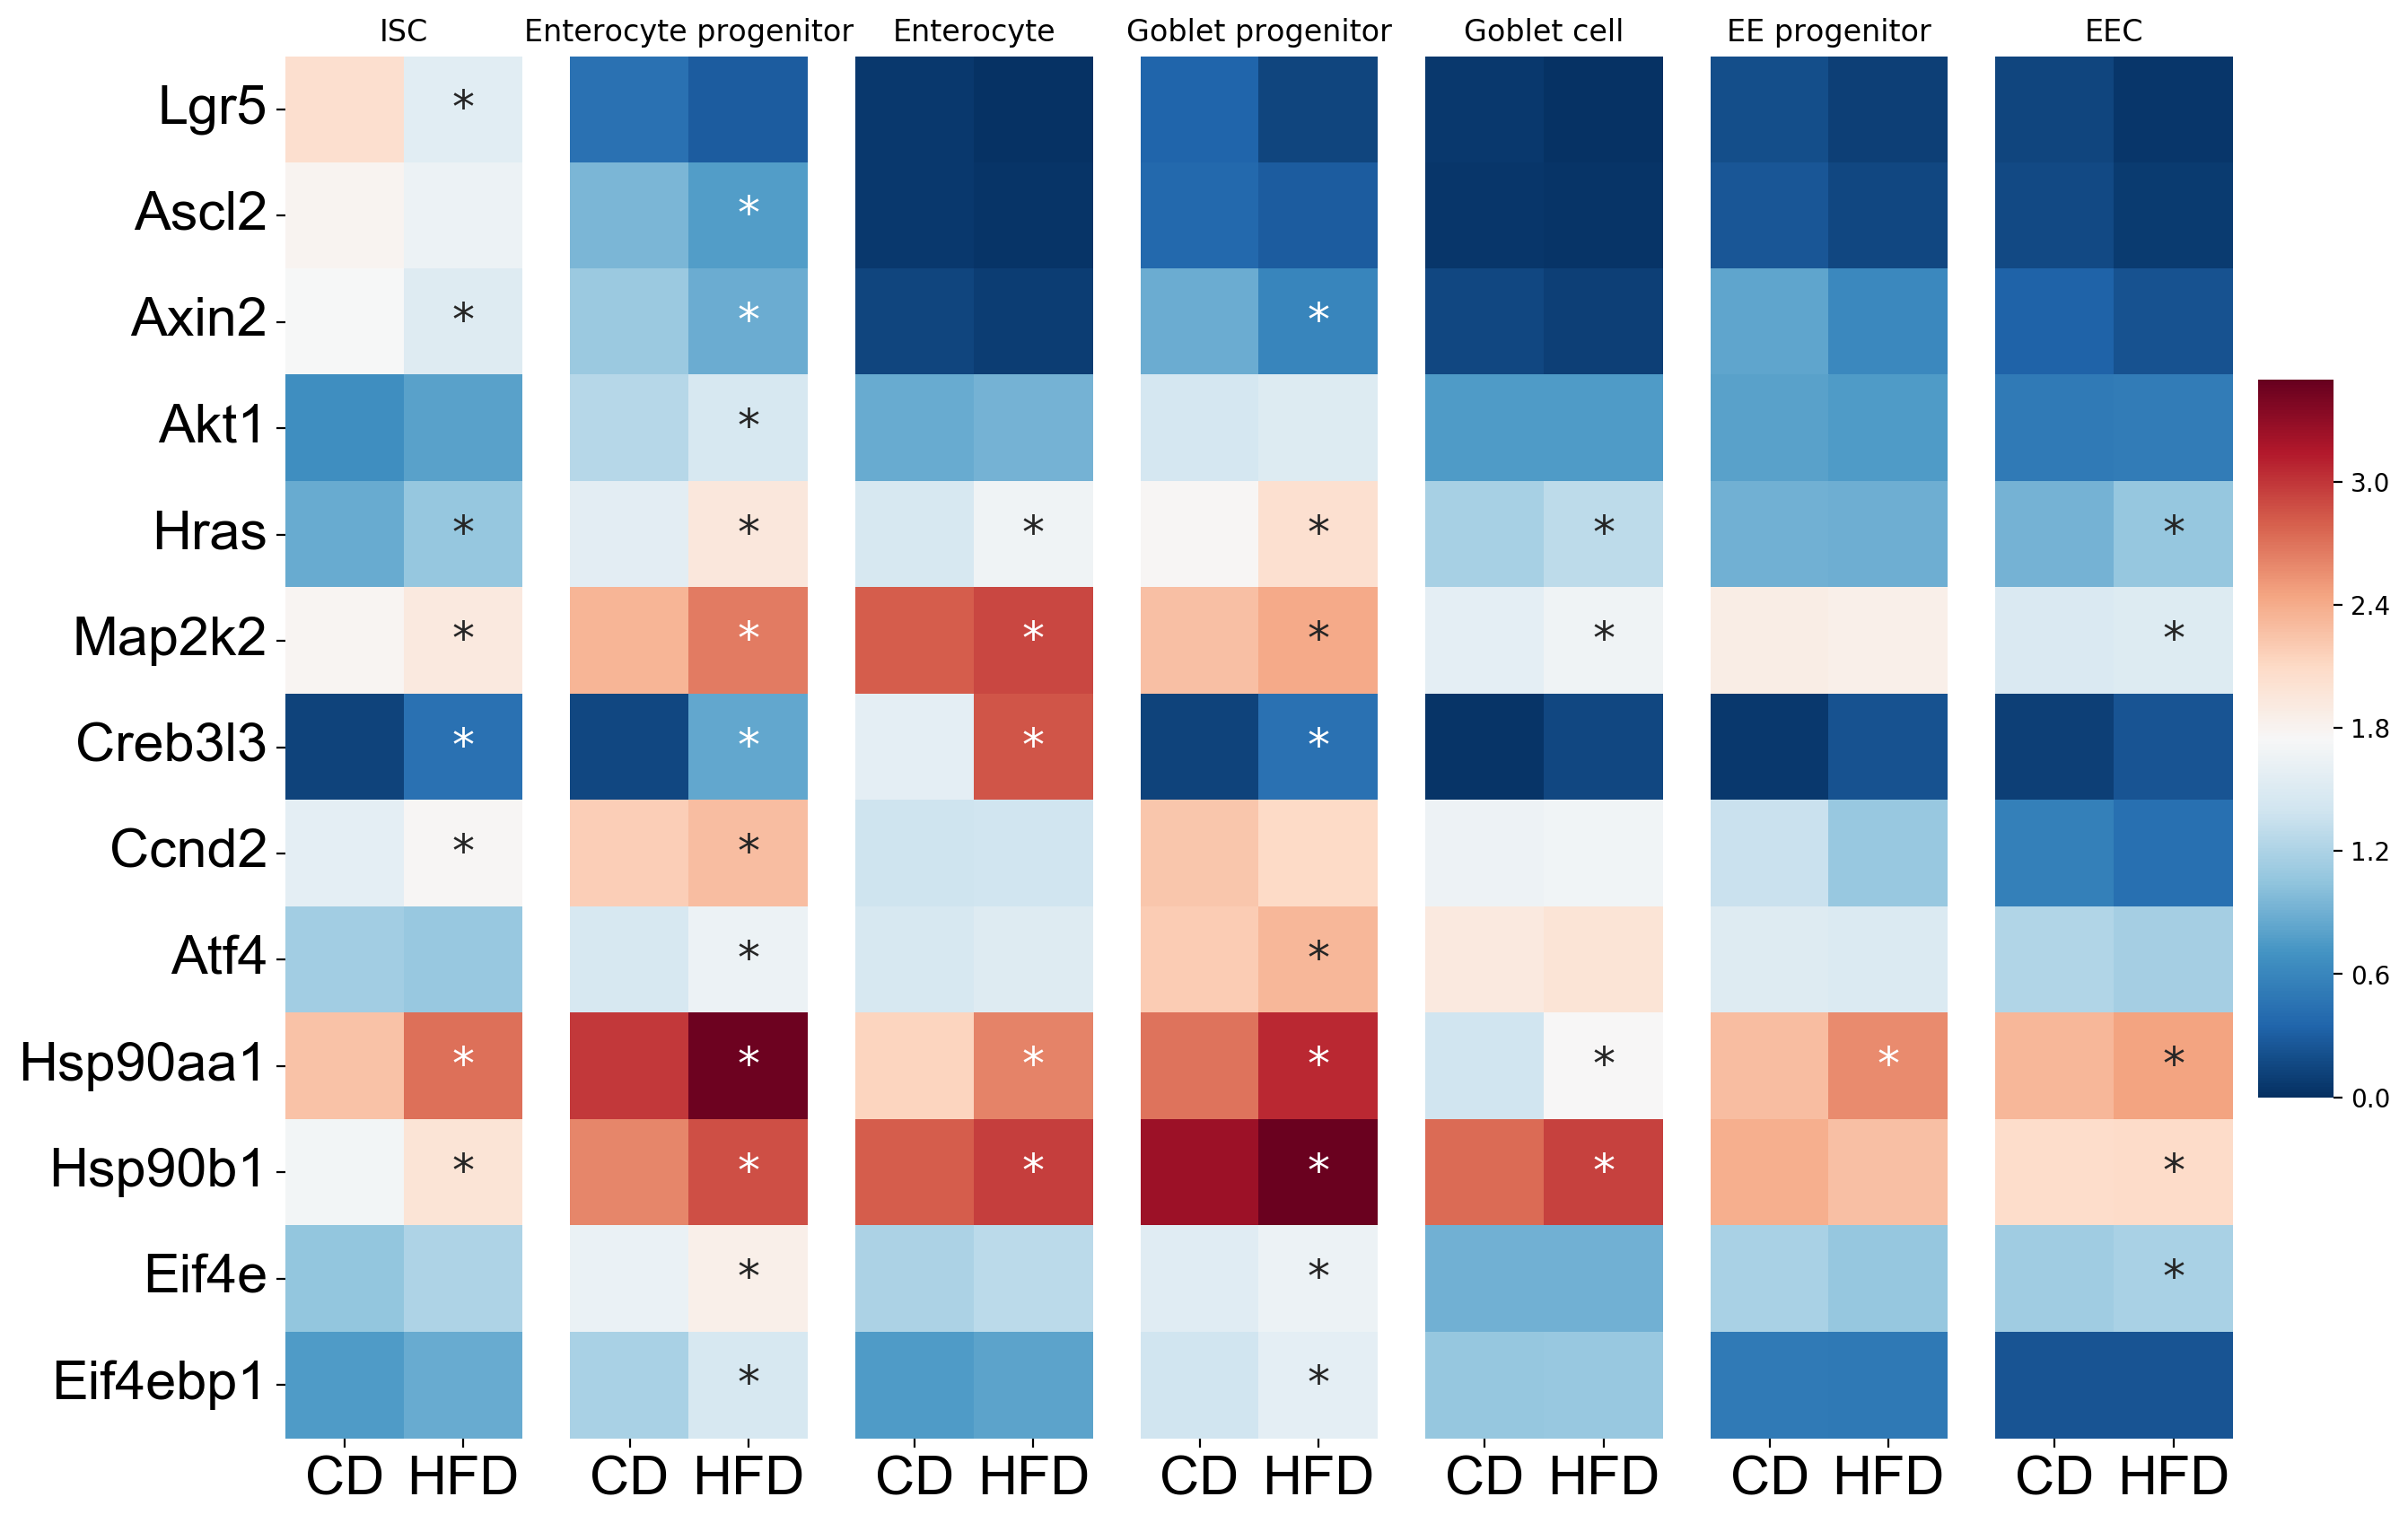

In [45]:
fig, axs = pl.subplots(ncols=len(cats), gridspec_kw={'wspace': 0.2}, figsize=(14, 10))
cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i,group in enumerate(cats):
    
    # subset cells and genes
    adata_sub = adata_all_scale[adata_all.obs['groups_named_prog4'].isin([group])].copy()
    adata_sub = adata_sub[:, gene_names].copy()

    # get mean expression per condition
    df = pd.DataFrame(adata_sub.X.toarray(), columns=adata_sub.var_names)
    df['diet'] = adata_sub.obs['diet'].values
    df_mean = df.groupby(['diet']).mean()[gene_names]

    try:   
        # upregulated genes
        data = pd.read_excel(filename, group+'_up', index_col=0)
        ix_fc = data['logFC']>0.1
        data_up = data[ix_fc]
        ix_p = data_up['adj.P.Val']<0.01
        data_up = data_up[ix_p]
        
        # downregulated genes
        data = pd.read_excel(filename, group+'_down', index_col=0)
        ix_fc = data['logFC']<-0.1
        data_down = data[ix_fc]
        ix_p = data_down['adj.P.Val']<0.01
        data_down = data_down[ix_p]
        
        genes_up = [gene for gene in gene_names if gene in data_up.index]
        genes_down = [gene for gene in gene_names if gene in data_down.index]

        annots = np.array([['','*'] if value else ['',''] for value in np.isin(df_mean.columns, genes_up+genes_down)])
        
        # plot
        sns.heatmap(df_mean.T, cmap='RdBu_r', ax=axs[i], cbar=i==0, yticklabels=i==0, cbar_ax=None if i else cbar_ax,
                    annot=annots, fmt='', vmin=0, vmax=3.5, annot_kws={'fontsize':18,'horizontalalignment':'center'})
                
        del annots
        
    except XLRDError:
        pass
    
    # plot if no significant genes
    if 'annots' not in locals():
        sns.heatmap(df_mean.T, cmap='RdBu_r', ax=axs[i], cbar=i==0, yticklabels=i==0, cbar_ax=None if i else cbar_ax, vmin=0, vmax=3.5)
    
    if i==0:
        axs[i].set_yticklabels(df_mean.columns, fontdict={'verticalalignment': 'center','rotation':0,'fontsize':22,'fontname':'Arial'})
        
    axs[i].set_title(group)
    axs[i].set_ylabel('')
    axs[i].set_xlabel('')
    axs[i].set_xticklabels(['CD','HFD'], fontdict={'rotation':0, 'fontsize':22, 'fontname':'Arial'})
    del df
    
fig.tight_layout(rect=[0, 0, .9, 1])
pl.savefig('./figures/S9_heatmap.pdf', dpi=600, format='pdf')
pl.show()
pl.rcParams.update(pl.rcParamsDefault)